# Introduction


For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude



Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback


In [ ]:
%matplotlib inline
print('Libraries imported.')

#  Importing the Data



The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [ ]:
df = pd.read_csv('data.csv', names = column_names)
df.head()

## Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [4]:
df.isna()

,serial,date,age,distance,stores,latitude,longitude,price
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False


In [5]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

We can see that there are no nun values

# Data Normalization



We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [6]:
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


We will skip the first column serial, there are several ways to do, one is 

In [7]:
df.iloc[:,1:].head()

,date,age,distance,stores,latitude,longitude,price
0,2009,21,9,6,84,121,14264
1,2007,4,2,3,86,121,12032
2,2016,18,3,7,90,120,13560
3,2002,13,2,2,80,128,12029
4,2014,25,5,8,81,122,14157


and we normalize

In [8]:
df = df.iloc[:,1:]
df_norm = (df - df.mean())/df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


##  Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [9]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)


print(convert_label_value(-1.836486), " that corresponds to the price 12032")

12031  that corresponds to the price 12032


# Create Training and Test Sets

## Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [10]:
x = df_norm.iloc[:,:6]
x.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


##  Select Labels

We select the prices

In [11]:
y = df_norm.iloc[:,-1:]
y.head()

,price
0,0.350088
1,-1.836486
2,-0.339584
3,-1.839425
4,0.245266


##  Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [12]:
x_arr = x.values
y_arr = y.values

print('features array shape', x_arr.shape)
print('labels array shape', y_arr.shape)

features array shape (5000, 6)
labels array shape (5000, 1)


## Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [13]:
x_train, x_test , y_train, y_test = train_test_split(x_arr,
                                                     y_arr, 
                                                     test_size = 0.05, 
                                                     random_state =0)
print( 'Training set', x_train.shape, y_train.shape)
print( 'Test set', x_test.shape, y_test.shape)

Training set (4750, 6) (4750, 1)
Test set (250, 6) (250, 1)


Let's write a function that returns an untrained model
of a certain architecture.
We're using a simple neural network architecture with just
three hidden layers.
We're going to use the rail you activation function on all
the layers except for the output layer.

#  Create the Model

We will use the sequential class from Keras.
And the cool thing about this class is you can just pass
on a list of layers to create your model architecture.

The first layer is a dense layer with just 10 nodes. 

We know that input shape is simply a list
of 6 values because we just have 6 features.

The activation is going to be really or rectified linear unit,
and the next layer will be again a fully connected or dense
layer. 

And this time, let's use 20 nodes and again, 
the same activation function relu and one more hidden layer with 5.
nodes and finally, the output layer with just 1 node.
so we have essentially, we have three hidden
layers.





## Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [14]:
def get_model():
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1) 
        
        
    ])
    
    model.compile(
         loss = 'mse',
         optimizer = 'adam'    
            )
    return model


This is the input and then we have three hidden layers.
but 10, 20 and five nodes respectively.
All the layers have activation function set to value
except for the output layer.
Since this is a regression problem, we just need the linear
output without any activation function here.

These are all fully connected layers, and the number
of parameters obviously correspond to the number of nodes
that we have.

We need to specify a loss function in this case means great
error, and we need to specify an optimizer.

In this case we are using Adam.

mse is a pretty common loss function used for regression problems.
Remember This is the loss function that the optimization
algorithm tries to minimize.
And we are using a variant of stochastic gradient descent
called Adam 

An optimization algorithm is for and that is to minimize
the loss of function.


In [15]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


The first dense layer that you see here is our first
hidden there, which has 10 nodes.

The next one has 20 nodes.
Next one has 5 nodes.
And the final one node, the output there has one, and you can see
that we have trainable parameters count 401.

Because these are dense layers, they are fully
connected layers and if you want to understand how
these parameters,count is arrived at, you can simply
multiply the nodes in your output layer in in any
one of these layers with the notes in the proceeding here.

So if you if you take a look at dense to for example,
we have 5 nodes and in the preceding layer that
is connected to we have 20 nodes, so each no disconnected.


Each node of dense one is connected to each note of dense two,
which means we have total 100 connections.
But you see that you have 105  parameters
for the Slayer.
Why is that?
That's simply because even though we have 100 weights, we
also have a bias or intercept,  in every layer.

Now that is just one interceptor connected to all the nodes
of the layer that you calculating these parameters for so
520 gives you 100 and five into one gives you 5,
and the total is 105 and you can do this exercise for all
the layers and arrive at the same number of trainable
parameters.




#  Model Training



We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [17]:
es_cb = EarlyStopping(monitor='val_loss',patience=5)
model = get_model()
preds_on_untrained = model.predict(x_test)
history = model.fit(
        x_train,y_train,
        validation_data =(x_test,y_test),
        epochs = 100,
        callbacks = [es_cb]

)

Epoch 1/100
149/149 [==============================] - 1s 3ms/step - loss: 0.6905 - val_loss: 0.2966
Epoch 2/100
149/149 [==============================] - 0s 1ms/step - loss: 0.2348 - val_loss: 0.1922
Epoch 3/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1783 - val_loss: 0.1677
Epoch 4/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1676 - val_loss: 0.1666
Epoch 5/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1631 - val_loss: 0.1633
Epoch 6/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1602 - val_loss: 0.1612
Epoch 7/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1589 - val_loss: 0.1616
Epoch 8/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1562 - val_loss: 0.1602
Epoch 9/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1558 - val_loss: 0.1608
Epoch 10/100
149/149 [==============================] - 0s 1ms/step - loss: 0.1561 - val_lo

##  Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

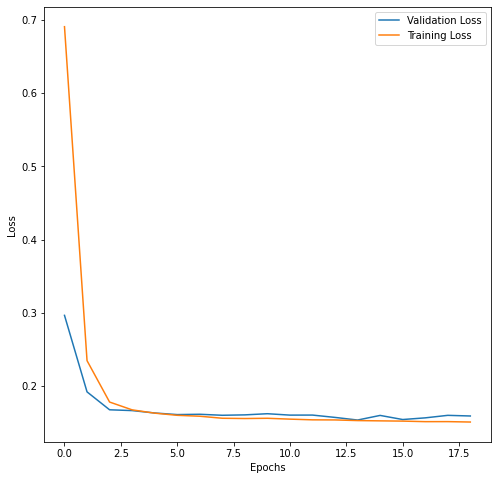

In [18]:
plot_loss(history)

The training and validation loss.
Values decreased as the training then don, and that's great.
But we don't know yet if the train model actually makes
reasonably accurate predictions.
So let's take a look at that.
Now. Remember that we had some predictions on the untrained
model. Similarly, we will make some predictions on the train
model on the same data set, of course, which is X test.

#  Predictions

##  Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

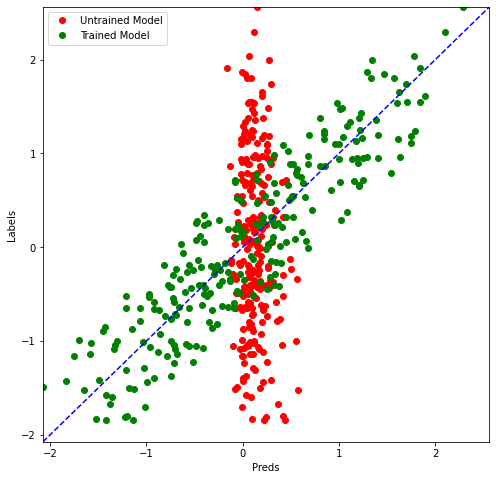

In [20]:
preds_on_trained = model.predict(x_test)
compare_predictions(preds_on_untrained,preds_on_trained,y_test)

You can see the pattern.
It's pretty much a linear, uh, plot for the train model.
Predictions now it's making mistakes, of course, but the
extent of those mistakes is, ah drastically less compared to
what's happening on the N train model.
So, in an ideal situation, our model should make predictions
same as labels.
And that means this dotted blue line, right?
But our green, uh, train model predictions are sort of
following this started blue line, which means that our model
training did actually work.

## Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

In [23]:
price_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_trained = [convert_label_value(y) for y in preds_on_trained]
price_test= [convert_label_value(y) for y in y_test]

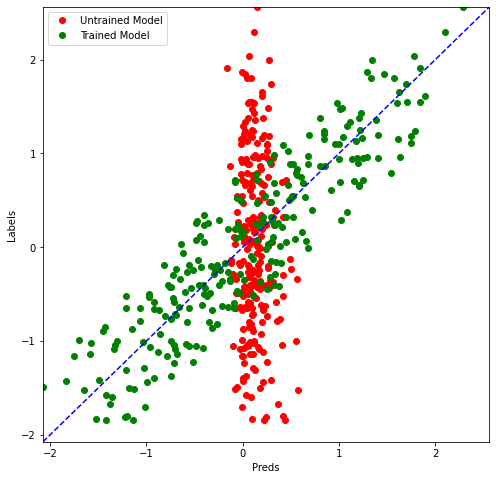

In [24]:
compare_predictions(preds_on_untrained,preds_on_trained,y_test)

We pretty much get the same graph, but the ranges are now
different. You can see the ranges from 12,000 to 16,000 or something for
both predictions and labels You can see that the train model is a lot more
aligned in its predictions to ground truth compared to the
untrained model.

<IPython.core.display.Javascript object>